In [2]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import re

font = {'family' : 'sans serif', 'size' : 18}
matplotlib.rc('font', **font)

path = os.getcwd()
log_json_path = os.path.join(path, "log.json")
log_text_path = os.path.join(path, "log.txt")

The best agent from a checkpoint was retrained with
```
params = {
    "q_architecture": (64, 64),
    "q_activation_function": torch.nn.ReLU,
    "q_lr": 1e-3,
    "policy_architecture": (64, 64),
    "policy_activation_function": torch.nn.ReLU,
    "policy_lr": 1e-3,
    "update_alpha": True, # Automatic exploration
    "exploration_timesteps": 0, # Don't get data that cause you to forget
    "update_start_in_timesteps": 10_000,
    "update_frequency_in_episodes": 1 # Increase update frequency
}

```

The sample efficiency was calculated from an agent with
```
def __init__(
    self,
    env_specs,
    gamma: float = 0.99,
    polyak: float = 0.995,
    q_lr: float = 1e-3,
    q_architecture: tuple = (64, 64),
    q_activation_function: F = nn.ReLU,
    policy_lr: float = 1e-3,
    policy_architecture: tuple = (64, 64),
    policy_activation_function: F = nn.ReLU,
    buffer_size: int = 1_000_000,
    alpha: float = 0.8,
    exploration_timesteps: int = 100,
    update_frequency_in_episodes: int = 1,
    update_start_in_episodes: int = 100,
    number_of_batch_updates: int = 1_000,
    batch_size: int = 100,
)
```

In [3]:
# Get the rewards
with open(log_json_path, "r") as f:
    json_log = json.load(f)
rewards = json_log["list_of_rewards"]

In [4]:
# Get the timsteps from the log
with open(log_text_path, "r") as f:
    log_lines = f.readlines()

In [5]:
# Collect timesteps
update_timesteps = []
for line in log_lines:
    if "Timestep" in line:
        timestep = re.search(r"Timestep: (\d+)", line).group(1)
        update_timesteps.append(timestep)
update_timesteps = [10_000, *update_timesteps] # Add the first timestep where lr = 1e-3
len(update_timesteps)

3024

In [6]:
# Track the learning rate scheduler and match with timesteps
import torch
tensor = torch.tensor(6.7, requires_grad=True)
optimizer = torch.optim.Adam([tensor], lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100)
learning_rate = [0.001]
for timestep in update_timesteps[1:]:
    scheduler.step()
    learning_rate.append(scheduler.get_last_lr()[0])
len(learning_rate)

/home/c_spino/anaconda3/envs/test_rl_project_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3024

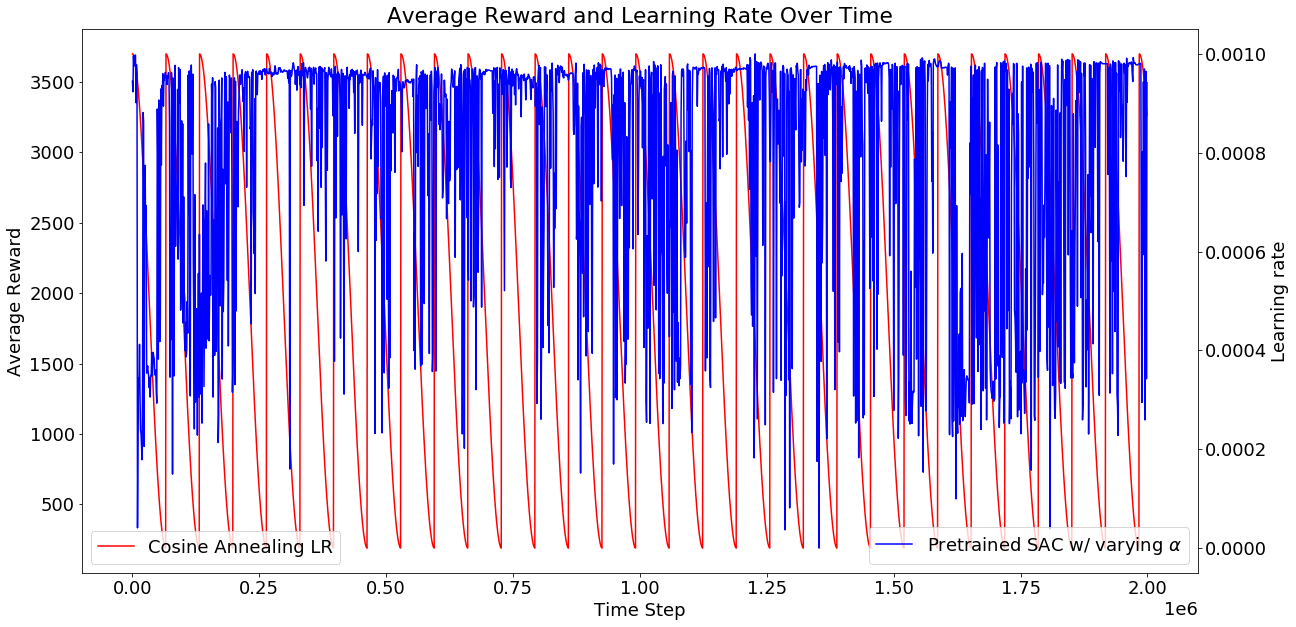

In [8]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111, label="3")
ax3=fig.add_subplot(111, label="1", frame_on=False)

plt2 = ax.plot(update_timesteps, learning_rate, color="red", zorder=5, label="Cosine Annealing LR")
ax.set_ylabel("Learning rate")
ax.yaxis.set_label_position('right') 
ax.yaxis.tick_right()
ax.set_xticks([])
ax.legend(loc="lower left")

x = np.arange(0, 2_000_000, 1_000)
plt1 = ax3.plot(x, rewards, color="blue", zorder=-1, label="Pretrained SAC w/ varying $\\alpha$")
ax3.set_title("Average Reward and Learning Rate Over Time")
ax3.set_xlabel("Time Step")
ax3.set_ylabel("Average Reward")
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.legend(loc="lower right")

plt.savefig("avg_rewards_cosine_annealing.png", bbox_inches="tight")
plt.show()

In [ ]:
# Do another one with just the varying alpha

In [9]:
# Sample efficiency plot
path = os.getcwd()
log_text_sample_eff_path = os.path.join(path, "log_sample_efficiency.txt")
with open(log_text_sample_eff_path, "r") as f:
    log_text_sample_eff = f.readlines()
average_rewards = [re.search(r"acc_reward: (\d+)", line).group(1) for line in log_text_sample_eff if "acc_reward" in line]

In [10]:
average_rewards_array = np.zeros((5, int(len(average_rewards)/5) + 1))
start = 0
end = 0
for i in range(5):
    start = end
    end = start + int(len(average_rewards)/5)
    average_rewards_array[i, :] = [0] + average_rewards[start:end]

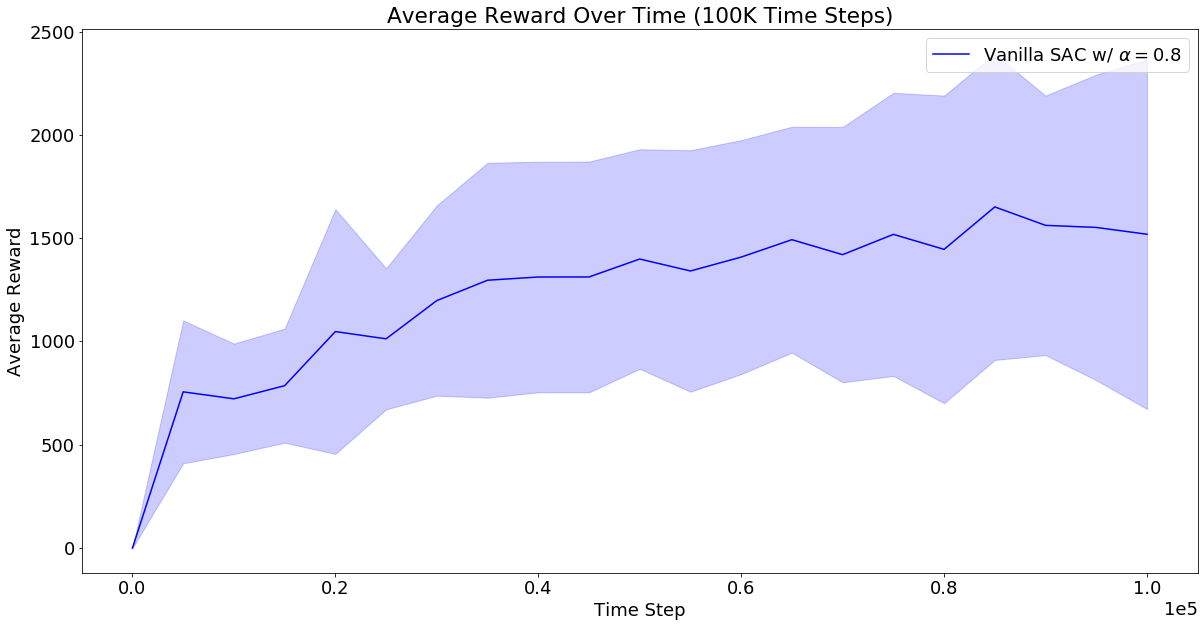

In [11]:
plt.figure(figsize=(20,10))

mean_average_rewards = np.mean(average_rewards_array, axis=0)
std_average_rewards = np.std(average_rewards_array, axis=0)
sample_eff_x = np.arange(0, 100_001, 5_000)

plt.plot(sample_eff_x, mean_average_rewards, color="blue", label="Vanilla SAC w/ $\\alpha = 0.8$")
plt.fill_between(sample_eff_x, mean_average_rewards - std_average_rewards, mean_average_rewards + std_average_rewards, alpha=0.2, color="blue")

plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.title("Average Reward Over Time (100K Time Steps)")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.savefig("avg_rewards_sample_efficiency.png", bbox_inches="tight")
plt.show()